<a href="https://colab.research.google.com/github/siddheshsp0/FinSearch-2025/blob/master/finsearch_final_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trading indicators(for state)

In [21]:
def calculate_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

In [22]:

def calculate_bollinger_bands(Close, window=20):
    rolling_mean = Close.rolling(window=window).mean()
    rolling_std = Close.rolling(window=window).std()

    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, lower_band

In [23]:
def calculate_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

In [24]:
def calculate_rsi(Close, period=14):
    delta = Close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    rsi[avg_loss == 0] = 100

    return rsi

In [30]:
import numpy as np
import pandas as pd

# --- Step 1: Define indicator functions in the global scope ---

def calculate_macd(series, fast=12, slow=26, signal=9):
    """Calculates the MACD value."""
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    return macd

def calculate_bollinger_bands(series, window=20):
    """Calculates the Upper and Lower Bollinger Bands."""
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, lower_band

def calculate_ema(series, span):
    """Calculates the Exponential Moving Average."""
    return series.ewm(span=span, adjust=False).mean()

def calculate_rsi(series, period=14):
    """
    Calculates the Relative Strength Index (RSI) using the standard
    Exponentially Weighted Moving Average (Wilder's Smoothing).
    """
    delta = series.diff()
    gain = delta.clip(lower=0).fillna(0)
    loss = -delta.clip(upper=0).fillna(0)

    # Use ewm for Wilder's Smoothing
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan).fillna(0) # Handle division by zero
    rsi = 100 - (100 / (1 + rs))
    return rsi

# --- Step 2: Update the main function ---

def add_technical_indicators(df, tech_indicator_list):
    """
    Calculate and add technical indicators to the DataFrame.
    This version prevents lookahead bias and uses improved calculations.
    """
    df_copy = df.copy()
    processed_dfs = []

    # Calculate indicators for each stock ticker to avoid data leakage
    for tic in df_copy['tic'].unique():
        tic_df = df_copy[df_copy['tic'] == tic].copy()

        if 'EMA_10' in tech_indicator_list:
            tic_df['EMA_10'] = calculate_ema(tic_df['close'], span=10)
        if 'EMA_20' in tech_indicator_list:
            tic_df['EMA_20'] = calculate_ema(tic_df['close'], span=20)
        if 'RSI_14' in tech_indicator_list:
            tic_df['RSI_14'] = calculate_rsi(tic_df['close'])
        if 'MACD' in tech_indicator_list:
            tic_df['MACD'] = calculate_macd(tic_df['close'])
        if 'BB_Upper' in tech_indicator_list and 'BB_Lower' in tech_indicator_list:
            tic_df['BB_Upper'], tic_df['BB_Lower'] = calculate_bollinger_bands(tic_df['close'])

        processed_dfs.append(tic_df)

    full_df = pd.concat(processed_dfs)

    # FIX: Remove bfill()/ffill() and use dropna() to eliminate lookahead bias
    full_df.dropna(inplace=True)

    # Sort by date and ticker to ensure correct order
    return full_df.sort_values(by=['date', 'tic']).reset_index(drop=True)

In [31]:
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np


## The GYm Env

In [50]:
class StockTradingEnv(gym.Env):
    """
    Corrected Stock Trading Environment.
    The episode number is now automatically updated inside the reset() method.
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, df, stock_dim, initial_balance, hmax=100,
                 transaction_cost_pct=0.001, reward_scaling=1e-4,
                 tech_indicator_list=['EMA_10', 'EMA_20', 'RSI_14', 'MACD', 'BB_Upper', 'BB_Lower'],
                 render_mode=None):
        super().__init__()

        self.df = df
        self.stock_dim = stock_dim
        self.initial_balance = initial_balance
        self.hmax = hmax
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.tech_indicator_list = tech_indicator_list
        self.render_mode = render_mode
        self.unique_trade_dates = self.df['date'].unique()

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.stock_dim,), dtype=np.float32)

        num_stock_features = 1 + len(self.tech_indicator_list)
        observation_space_shape = 1 + self.stock_dim + self.stock_dim * num_stock_features
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(observation_space_shape,), dtype=np.float32)

        self.day_index = 0
        self.balance = self.initial_balance
        self.shares_held = np.zeros(self.stock_dim, dtype=np.float32)
        self.portfolio_value = self.initial_balance
        self.episode_num = 0
        self.running_max_portfolio_value = self.initial_balance # Initialize running max
        self.previous_drawdown = 0 # Initialize previous drawdown

    # The update_episode and reset_episode methods are no longer needed.

    def _get_obs(self):
        day_data = self.df[self.df['date'] == self.unique_trade_dates[self.day_index]]
        stock_features = day_data[['close'] + self.tech_indicator_list].values.flatten()
        obs = np.concatenate(
            ([self.balance], self.shares_held, stock_features),
            dtype=np.float32,
        )
        return obs

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        # CORRECTED LOGIC: Increment episode number here
        # We check if day_index > 0 to avoid incrementing on the very first reset.
        if self.day_index > 0:
            self.episode_num += 1

        # Reset the environment to its initial state
        self.day_index = 0
        self.balance = self.initial_balance
        self.shares_held = np.zeros(self.stock_dim, dtype=np.float32)
        self.portfolio_value = self.initial_balance
        self.running_max_portfolio_value = self.initial_balance # Reset running max on episode reset
        self.previous_drawdown = 0 # Reset previous drawdown on episode reset


        observation = self._get_obs()
        info = {'portfolio_value': self.portfolio_value}

        if self.render_mode == 'human':
            self.render()

        return observation, info

    def step(self, actions):
        begin_portfolio_value = self.portfolio_value
        actions = (actions * self.hmax).astype(int)
        current_prices = self.df[self.df['date'] == self.unique_trade_dates[self.day_index]]['close'].values

        for i in range(self.stock_dim):
            if actions[i] < 0:
                sell_shares = min(abs(actions[i]), self.shares_held[i])
                sell_value = current_prices[i] * sell_shares
                self.shares_held[i] -= sell_shares
                self.balance += sell_value * (1 - self.transaction_cost_pct)

        for i in range(self.stock_dim):
            if actions[i] > 0:
                buy_shares = actions[i]
                buy_cost = current_prices[i] * buy_shares
                if self.balance >= buy_cost:
                    self.shares_held[i] += buy_shares
                    self.balance -= buy_cost * (1 + self.transaction_cost_pct)

        self.day_index += 1
        terminated = self.day_index >= (len(self.unique_trade_dates) - 1)

        if not terminated:
            new_prices = self.df[self.df['date'] == self.unique_trade_dates[self.day_index]]['close'].values
            self.portfolio_value = self.balance + np.sum(self.shares_held * new_prices)
        else:
            final_prices = self.df[self.df['date'] == self.unique_trade_dates[self.day_index - 1]]['close'].values
            self.portfolio_value = self.balance + np.sum(self.shares_held * final_prices)

        truncated = self.portfolio_value <= 0

        # Update running max portfolio value
        self.running_max_portfolio_value = max(self.running_max_portfolio_value, self.portfolio_value)

        reward = (self.portfolio_value - begin_portfolio_value) * self.reward_scaling
        # # 1. Add a penalty for drawdowns
        current_drawdown = (self.portfolio_value / self.running_max_portfolio_value) - 1
        if current_drawdown < self.previous_drawdown:
            reward -= 1 * abs(current_drawdown)

        self.previous_drawdown = current_drawdown # Update previous drawdown

        observation = self._get_obs()
        info = {'portfolio_value': self.portfolio_value}

        if self.render_mode == 'human':
            self.render()

        return observation, reward, terminated, bool(truncated), info

    def render(self):
        if self.render_mode == 'human':
            print(f"Day: {self.day_index}")
            print(f"Portfolio Value: {self.portfolio_value:,.2f}")
            print(f"Balance: {self.balance:,.2f}")
            print(f"Shares Held: {self.shares_held.round(0)}")
            print(f"Episode Number: {self.episode_num}")
            print("-" * 30)

    def close(self):
        pass

In [33]:
import yfinance as yf
print("Downloading real stock data...")

tickers = ['RELIANCE.NS', 'TCS.NS']
start_date = "2010-01-01"
end_date = "2019-06-30"

# Download all tickers at once. yfinance returns a wide-format DataFrame
# with a MultiIndex for the columns: ('Open', 'TCS.NS'), ('Close', 'RELIANCE.NS'), etc.
df_wide = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# --- 2. Convert and Format the Data from Wide to Long Format ---
print("Processing and combining data...")

# Stack the 'Ticker' level of the columns to convert to a long format
# The result is a Series with a MultiIndex: (Date, Ticker)
df_stacked = df_wide.stack(level=1)

# Reset the index to turn the MultiIndex into columns 'Date' and 'Ticker'
df_long = df_stacked.reset_index()

# Rename columns to be compatible with the environment
df_long.rename(columns={
    'Date': 'date',
    'Ticker': 'tic',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Adj Close': 'adj close',
    'Volume': 'volume'
}, inplace=True)

# Ensure data types are correct
df_long['date'] = pd.to_datetime(df_long['date'])

# Sort the data by date and ticker, which is crucial for the environment
sample_df = df_long.sort_values(by=['date', 'tic']).reset_index(drop=True)

# Drop any rows with missing values in critical columns
sample_df.dropna(subset=['close', 'open', 'high', 'low', 'volume'], inplace=True)

print("Data successfully loaded and formatted.")
print("Sample of loaded data:")
print(sample_df.head())

# --- 3. Preprocess Data: Add Technical Indicators ---
print("\nAdding technical indicators...")
INDICATORS = ['EMA_10', 'RSI_14', 'MACD', 'BB_Upper', 'BB_Lower']
df_processed = add_technical_indicators(sample_df, tech_indicator_list=INDICATORS)

print("Data preprocessing complete.")
print("Sample of processed data with indicators:")
print(df_processed.head())

#80-20 train test split
train_size = int(len(df_processed) * 0.8)
df_train = df_processed[:train_size]
df_test = df_processed[train_size:]


# --- 4. Instantiate and Validate the Environment ---
print("\nInstantiating the trading environment...")
STOCK_DIM = len(tickers)
INITIAL_BALANCE = 1_000_000

stock_trading_env = StockTradingEnv(
    df=df_train,
    stock_dim=STOCK_DIM,
    initial_balance=INITIAL_BALANCE,
    tech_indicator_list=INDICATORS,
    render_mode='human' # Set to 'human' to see output, or None for silent training
)

# Validate the environment using Gymnasium's checker
# This is a crucial step to ensure the environment follows the standard API
try:
    from gymnasium.utils.env_checker import check_env
    print("\nValidating the environment...")
    check_env(stock_trading_env)
    print("Environment check passed!")
except Exception as e:
    print(f"\nEnvironment check failed: {e}")

# --- 5. Test the Environment with Random Actions ---
print("\nTesting the environment with random actions for 5 steps...")
obs, info = stock_trading_env.reset()
for _ in range(100):
    action = stock_trading_env.action_space.sample() # Take a random action
    obs, reward, terminated, truncated, info = stock_trading_env.step(action)

    if terminated or truncated:
        print("  Episode finished early.")
        break


[*********************100%***********************]  2 of 2 completed

Processing and combining data...



/tmp/ipython-input-418810898.py:17: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_stacked = df_wide.stack(level=1)


Data successfully loaded and formatted.
Sample of loaded data:
Price       date          tic   adj close       close        high         low  \
0     2010-01-04  RELIANCE.NS  218.593079  245.841202  249.407104  233.577728   
1     2010-01-04       TCS.NS  295.397552  375.825012  379.450012  374.524994   
2     2010-01-05  RELIANCE.NS  217.617523  244.744003  262.847809  243.532516   
3     2010-01-05       TCS.NS  295.476105  375.924988  379.774994  373.274994   
4     2010-01-06  RELIANCE.NS  221.133728  248.698502  250.184296  244.732574   

Price        open    volume  
0      249.407104  76646086  
1      377.399994   1963682  
2      262.847809  21392825  
3      377.500000   2014488  
4      246.846970  23691760  

Adding technical indicators...
Data preprocessing complete.
Sample of processed data with indicators:
Price       date          tic   adj close       close        high         low  \
0     2010-02-01  RELIANCE.NS  212.475327  238.960861  241.155258  236.709305   
1    

/usr/local/lib/python3.11/dist-packages/gymnasium/utils/env_checker.py:311: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/env_checker.py:315: UserWarning: WARN: A Box observation space maximum value is infinity. This is probably too high.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:334: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


# **Implementing the PPO Algorithm**

In [ ]:
import math
import random
from dataclasses import dataclass
from typing import List, Tuple

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Minimal, fast PPO (continuous)
# Env: Pendulum-v1 by default
# PyTorch-only, single file, CPU-friendly
# -------------------------------


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


class MLPActorCritic(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int, hidden: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh()
        )
        self.mu = nn.Linear(hidden, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))
        self.v = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.log_std, self.v(h)

    @torch.no_grad()
    def act(self, obs: torch.Tensor):
        mu, log_std, value = self.forward(obs)
        std = log_std.exp()
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        logp = dist.log_prob(action).sum(axis=-1)
        return action, logp, value.squeeze(-1)


@dataclass
class Rollout:
    obs: List[np.ndarray]
    acts: List[np.ndarray]
    logps: List[float]
    rews: List[float]
    dones: List[bool]
    vals: List[float]
    next_obs: np.ndarray
    next_val: float


def compute_gae(roll: Rollout, gamma: float, lam: float):
    rews = np.array(roll.rews, dtype=np.float32)
    dones = np.array(roll.dones, dtype=np.bool_)
    vals = np.array(roll.vals + [roll.next_val], dtype=np.float32)
    adv = np.zeros_like(rews, dtype=np.float32)
    gae = 0.0
    for t in reversed(range(len(rews))):
        delta = rews[t] + gamma * vals[t + 1] * (1.0 - float(dones[t])) - vals[t]
        gae = delta + gamma * lam * (1.0 - float(dones[t])) * gae
        adv[t] = gae
    ret = adv + vals[:-1]
    return adv, ret


class PPO:
    def __init__(self, obs_dim, act_dim, lr=3e-4, clip_ratio=0.2, vf_coef=0.5, ent_coef=0.0, max_grad_norm=0.5, hidden=64, device="cpu"):
        self.device = torch.device(device)
        self.ac = MLPActorCritic(obs_dim, act_dim, hidden).to(self.device)
        self.opt = optim.Adam(self.ac.parameters(), lr=lr)
        self.clip_ratio = clip_ratio
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm

    def update(self, batch, epochs, minibatch_size):
        obs = torch.as_tensor(batch["obs"], dtype=torch.float32, device=self.device)
        acts = torch.as_tensor(batch["acts"], dtype=torch.float32, device=self.device)
        old_logps = torch.as_tensor(batch["logps"], dtype=torch.float32, device=self.device)
        advs = torch.as_tensor(batch["advs"], dtype=torch.float32, device=self.device)
        rets = torch.as_tensor(batch["rets"], dtype=torch.float32, device=self.device)

        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        n = obs.shape[0]
        idxs = np.arange(n)

        for _ in range(epochs):
            np.random.shuffle(idxs)
            for start in range(0, n, minibatch_size):
                mb = idxs[start:start+minibatch_size]
                mu, log_std, values = self.ac(obs[mb])
                std = log_std.exp()
                dist = torch.distributions.Normal(mu, std)
                logps = dist.log_prob(acts[mb]).sum(axis=-1)
                entropy = dist.entropy().sum(axis=-1).mean()
                ratio = (logps - old_logps[mb]).exp()
                unclipped = ratio * advs[mb]
                clipped = torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * advs[mb]
                policy_loss = -torch.min(unclipped, clipped).mean()
                value_loss = nn.functional.mse_loss(values.squeeze(-1), rets[mb])
                loss = policy_loss + self.vf_coef * value_loss - self.ent_coef * entropy
                self.opt.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(self.ac.parameters(), self.max_grad_norm)
                self.opt.step()

    @torch.no_grad()
    def act(self, obs_t: torch.Tensor):
        return self.ac.act(obs_t)


def collect_rollout(env, agent, n_steps, obs, gamma):
    obs_buf, act_buf, logp_buf, rew_buf, done_buf, val_buf = [], [], [], [], [], []
    for _ in range(n_steps):
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=agent.device).unsqueeze(0)
        action, logp, value = agent.act(obs_t)
        action_np = action.cpu().numpy()[0]
        next_obs, reward, terminated, truncated, _ = env.step(action_np)
        done = terminated or truncated
        obs_buf.append(obs)
        act_buf.append(action_np)
        logp_buf.append(float(logp.item()))
        rew_buf.append(float(reward))
        done_buf.append(bool(done))
        val_buf.append(float(value.item()))
        obs = next_obs
        if done:
            obs, _ = env.reset()
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=agent.device).unsqueeze(0)
    _, _, next_val = agent.act(obs_t)
    return Rollout(obs_buf, act_buf, logp_buf, rew_buf, done_buf, val_buf, obs, float(next_val.item()))


def make_batch(roll, gamma, lam):
    adv, ret = compute_gae(roll, gamma, lam)
    return {
        "obs": np.array(roll.obs, dtype=np.float32),
        "acts": np.array(roll.acts, dtype=np.float32),
        "logps": np.array(roll.logps, dtype=np.float32),
        "advs": adv.astype(np.float32),
        "rets": ret.astype(np.float32)
    }


# def train(total_timesteps=200_000, n_steps=1024, batch_epochs=10, minibatch_size=64, gamma=0.99, gae_lambda=0.95, seed=42, device="cuda"):
#     set_seed(seed)
#     env = stock_trading_env
#     obs, _ = env.reset(seed=seed)
#     obs_dim = env.observation_space.shape[0]
#     act_dim = env.action_space.shape[0]
#     agent = PPO(obs_dim, act_dim, device=device)
#     steps_collected = 0
#     while steps_collected < total_timesteps:
#         roll = collect_rollout(env, agent, n_steps, obs, gamma)
#         obs = roll.next_obs
#         batch = make_batch(roll, gamma, gae_lambda)
#         agent.update(batch, epochs=batch_epochs, minibatch_size=minibatch_size)
#         steps_collected += n_steps
#         if steps_collected % (n_steps * 10) == 0:
#             print(f"Steps {steps_collected}")
#     env.close()


# if __name__ == "__main__":
#     train()


--- Starting Agent Training ---
  Training Batch 1/24 | Timesteps: 2048/50000 | Total Reward: 60.14 | Final Portfolio: $1,135,727.17
  Training Batch 2/24 | Timesteps: 4096/50000 | Total Reward: 25.05 | Final Portfolio: $962,032.68
  Training Batch 3/24 | Timesteps: 6144/50000 | Total Reward: -77.55 | Final Portfolio: $982,727.30
  Training Batch 4/24 | Timesteps: 8192/50000 | Total Reward: 80.13 | Final Portfolio: $1,775,805.46
  Training Batch 5/24 | Timesteps: 10240/50000 | Total Reward: 130.86 | Final Portfolio: $1,682,577.76
  Training Batch 6/24 | Timesteps: 12288/50000 | Total Reward: 107.16 | Final Portfolio: $2,232,961.12
  Training Batch 7/24 | Timesteps: 14336/50000 | Total Reward: 220.96 | Final Portfolio: $2,900,512.72
  Training Batch 8/24 | Timesteps: 16384/50000 | Total Reward: 86.40 | Final Portfolio: $2,788,587.21
  Training Batch 9/24 | Timesteps: 18432/50000 | Total Reward: 111.37 | Final Portfolio: $2,815,806.75
  Training Batch 10/24 | Timesteps: 20480/50000 | Tot

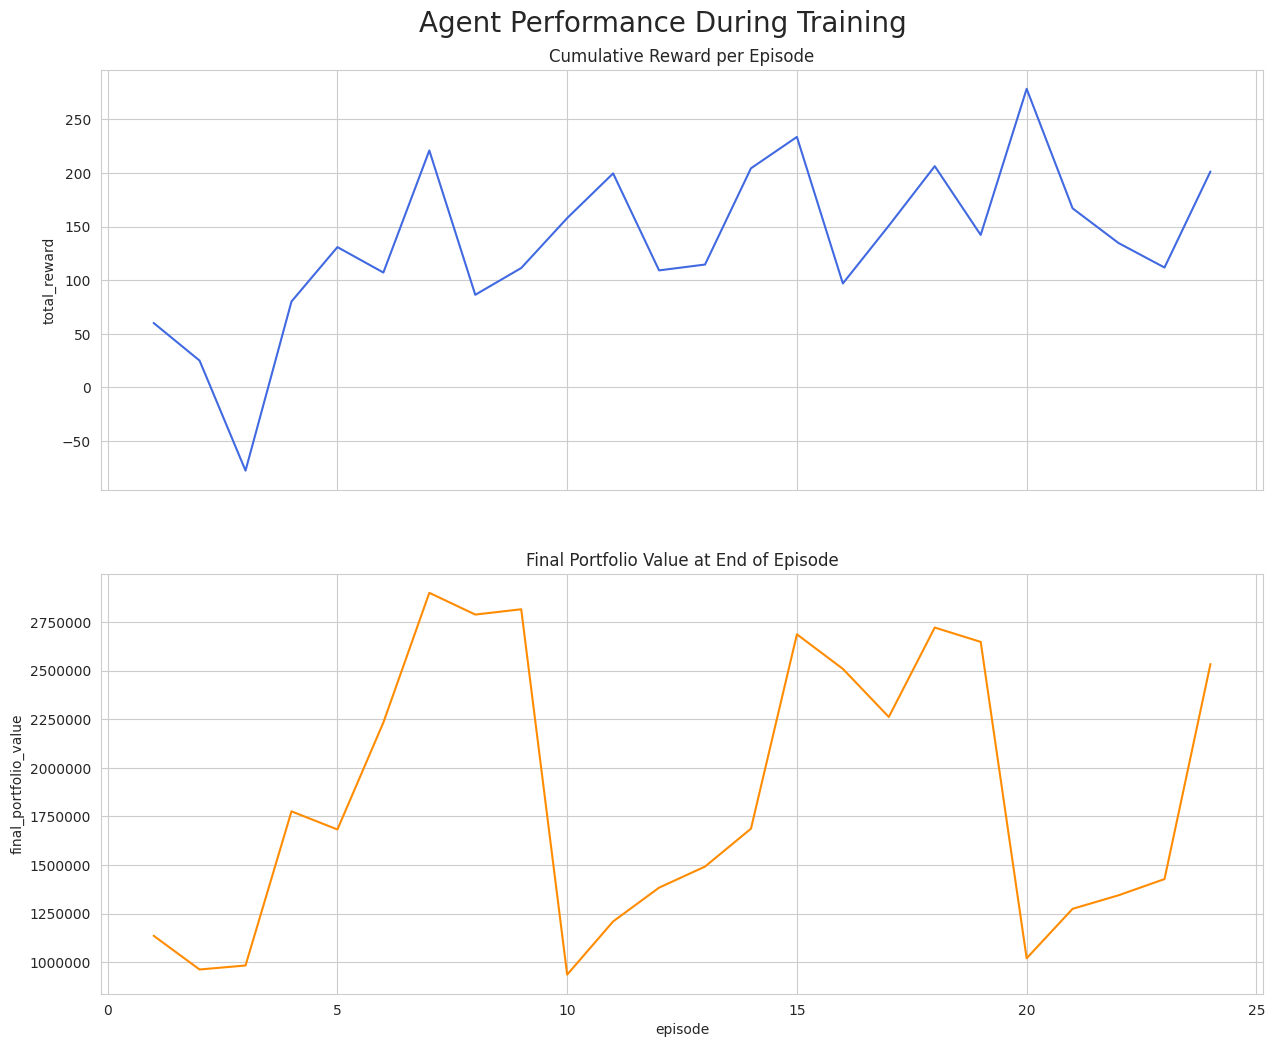


--- Generating Test Performance Plots ---


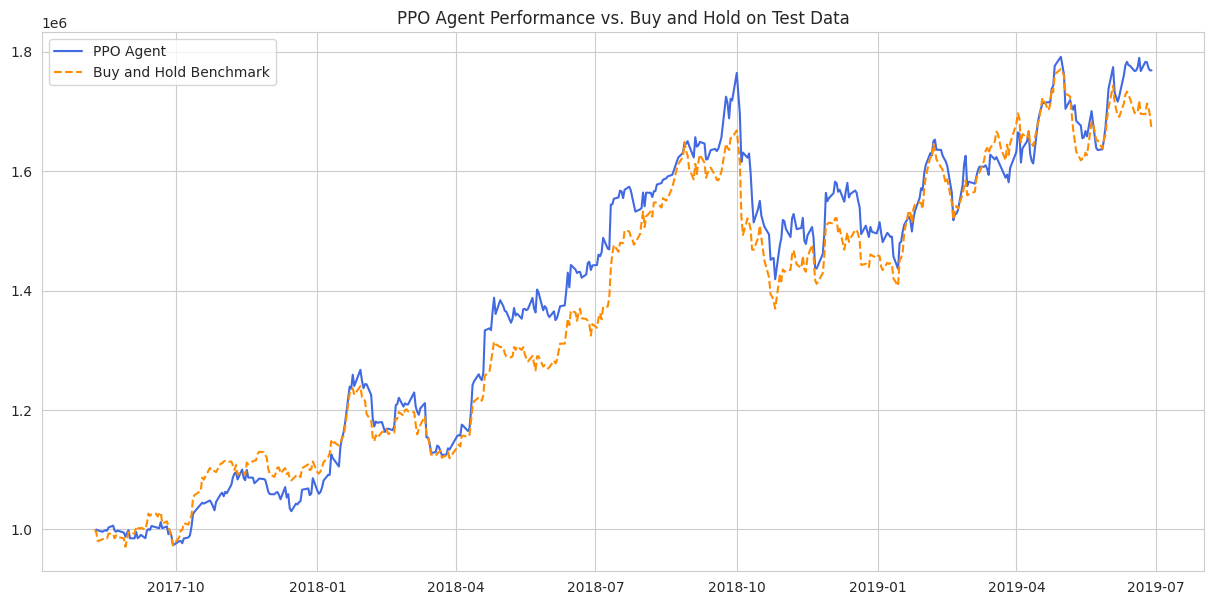

/tmp/ipython-input-249695456.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


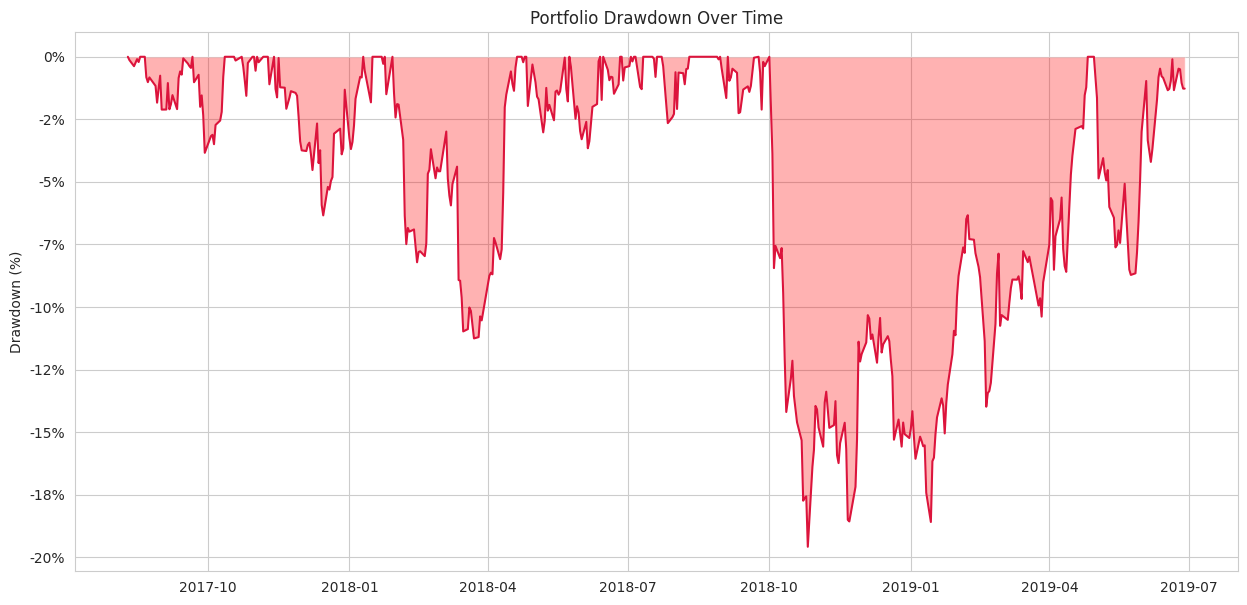

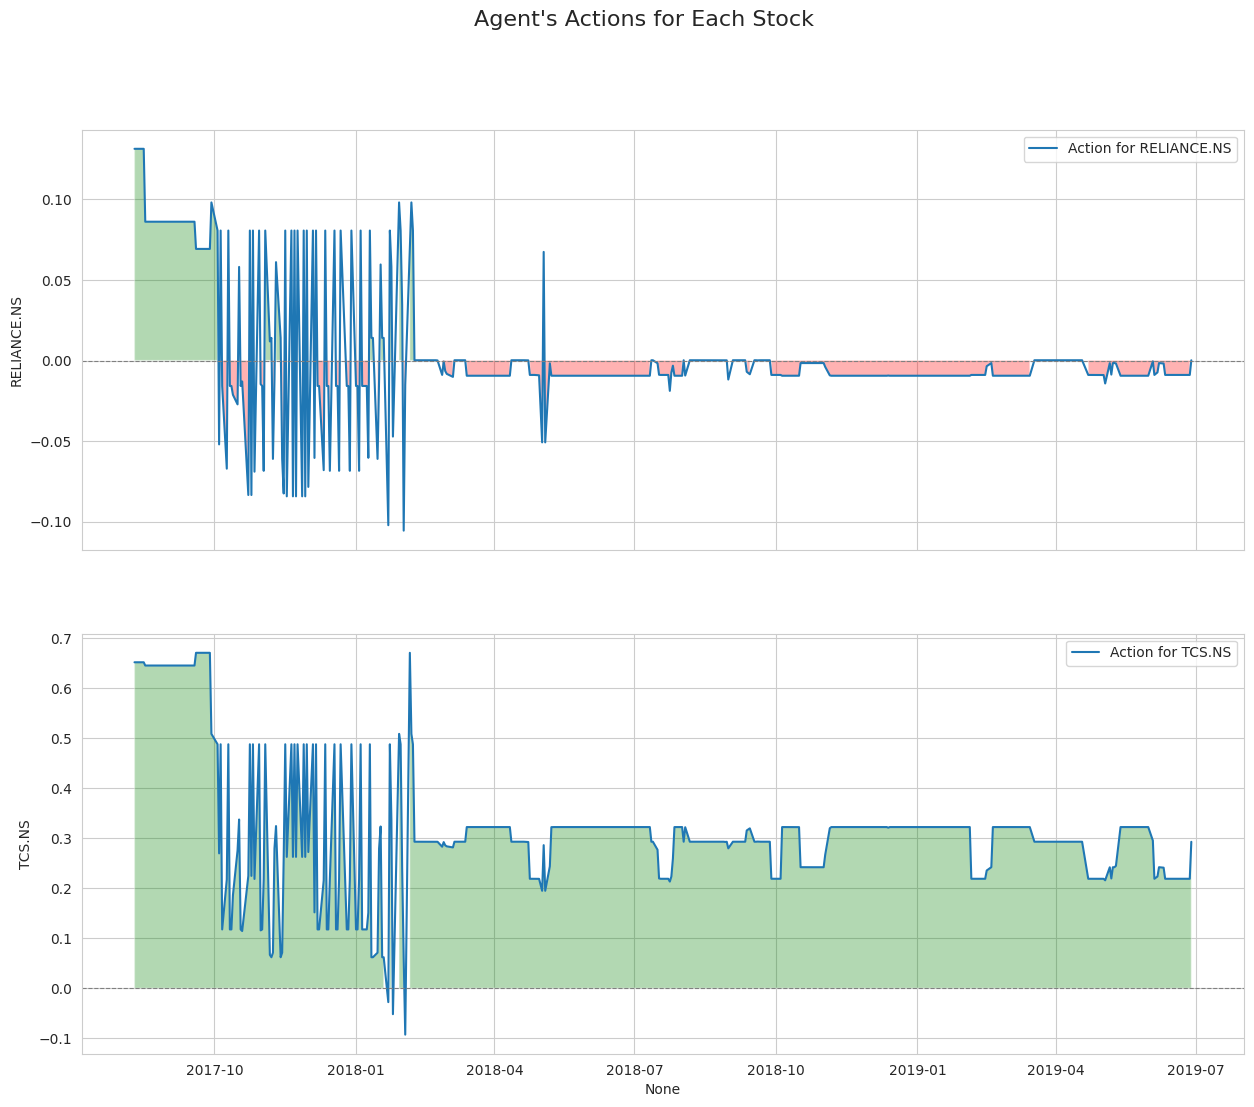

/tmp/ipython-input-249695456.py:193: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])


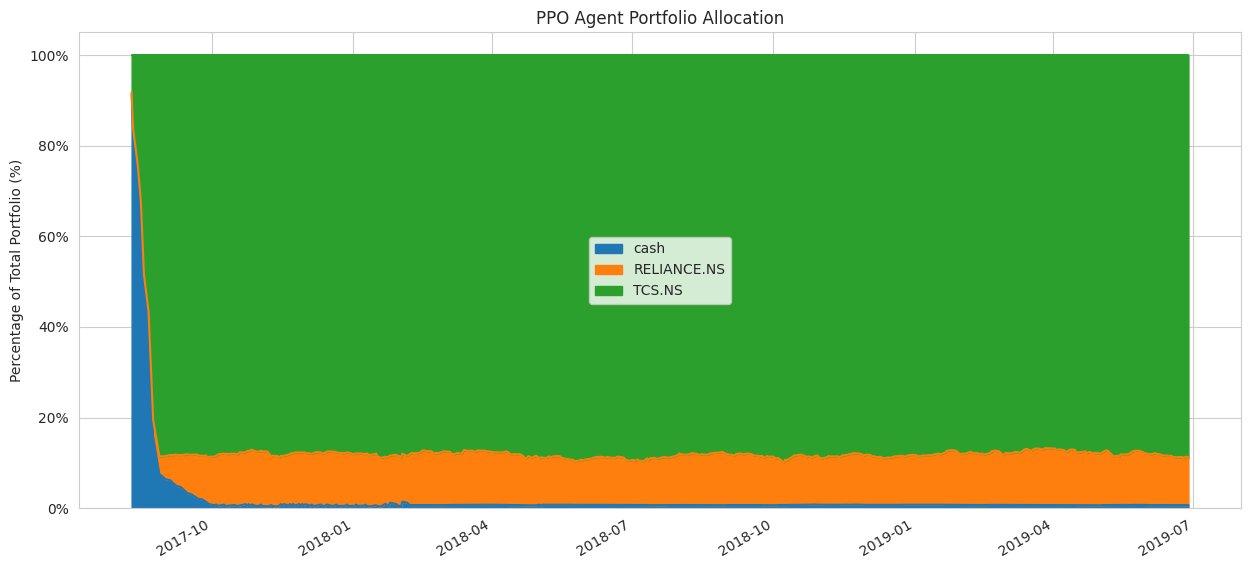

In [51]:
# --- This cell contains all the code for training, evaluation, risk analysis, and plotting ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [15, 8]

# --- 1. MODIFIED TRAIN FUNCTION TO RETURN AGENT & TRAINING HISTORY ---
def train(env, total_timesteps=50_000, n_steps=2048, batch_epochs=10, minibatch_size=64, gamma=0.99, gae_lambda=0.96, seed=42, device="cuda"):
    """
    Modified train function to return the trained agent AND a history of training performance.
    """
    set_seed(seed)
    obs, _ = env.reset(seed=seed)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    agent = PPO(obs_dim, act_dim, device=device)
    steps_collected = 0

    episode_rewards_history = []
    episode_portfolio_history = []

    print("--- Starting Agent Training ---")
    num_episodes = total_timesteps // n_steps
    for episode in range(num_episodes):
        roll = collect_rollout(env, agent, n_steps, obs, gamma)
        obs = roll.next_obs
        batch = make_batch(roll, gamma, gae_lambda)
        agent.update(batch, epochs=batch_epochs, minibatch_size=minibatch_size)
        steps_collected += n_steps

        total_reward = sum(roll.rews)
        final_portfolio_value = env.portfolio_value
        episode_rewards_history.append(total_reward)
        episode_portfolio_history.append(final_portfolio_value)

        print(f"  Training Batch {episode + 1}/{num_episodes} | Timesteps: {steps_collected}/{total_timesteps} | Total Reward: {total_reward:.2f} | Final Portfolio: ${final_portfolio_value:,.2f}")

    print("--- Training Complete ---")
    env.close()

    training_history_df = pd.DataFrame({
        'episode': range(1, num_episodes + 1),
        'total_reward': episode_rewards_history,
        'final_portfolio_value': episode_portfolio_history
    })

    return agent, training_history_df


# --- 2. ENHANCED EVALUATION FUNCTION WITH RISK METRICS ---
@torch.no_grad()
def evaluate_agent(env, agent, tickers):
    """
    Evaluate the agent and calculate performance and risk metrics.
    """
    obs, info = env.reset()
    terminated, truncated = False, False

    portfolio_values = [env.initial_balance]
    actions_history = []
    asset_values = []

    while not (terminated or truncated):
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=agent.device).unsqueeze(0)
        mu, _, _ = agent.ac(obs_t)
        action = mu.cpu().numpy()[0]
        obs, reward, terminated, truncated, info = env.step(action)

        portfolio_values.append(info['portfolio_value'])
        actions_history.append(action)

        current_prices = env.df[env.df['date'] == env.unique_trade_dates[env.day_index-1]]['close'].values
        allocation = {'cash': env.balance}
        for i, ticker in enumerate(tickers):
            allocation[ticker] = env.shares_held[i] * current_prices[i]
        asset_values.append(allocation)

    dates = env.unique_trade_dates[1:len(portfolio_values)]
    portfolio_df = pd.DataFrame({'date': dates, 'portfolio_value': portfolio_values[1:]}).set_index('date')
    actions_df = pd.DataFrame(actions_history, columns=tickers, index=dates)
    assets_df = pd.DataFrame(asset_values, index=dates)
    assets_df_percentage = assets_df.divide(assets_df.sum(axis=1), axis=0)

    # --- Risk and Performance Calculations ---
    risk_free_rate = 0.02
    trading_days = 252

    daily_returns = portfolio_df['portfolio_value'].pct_change().dropna()

    # --- ADDED FINAL PORTFOLIO VALUE ---
    final_portfolio_value = portfolio_df['portfolio_value'].iloc[-1]
    average_portfolio_value = portfolio_df['portfolio_value'].mean()
    total_return = (final_portfolio_value / portfolio_df['portfolio_value'].iloc[0]) - 1
    annualized_volatility = daily_returns.std() * np.sqrt(trading_days)
    sharpe_ratio = (daily_returns.mean() * trading_days - risk_free_rate) / annualized_volatility

    rolling_max = portfolio_df['portfolio_value'].cummax()
    daily_drawdown = (portfolio_df['portfolio_value'] / rolling_max) - 1
    max_drawdown = daily_drawdown.min()

    negative_returns = daily_returns[daily_returns < 0]
    downside_deviation = negative_returns.std() * np.sqrt(trading_days)

    sortino_ratio = (daily_returns.mean() * trading_days - risk_free_rate) / downside_deviation if downside_deviation != 0 else 0
    calmar_ratio = (daily_returns.mean() * trading_days) / abs(max_drawdown) if max_drawdown != 0 else 0

    risk_metrics = {
        'Average Portfolio Value': f"${average_portfolio_value:,.2f}",
        'Final Portfolio Value': f"${final_portfolio_value:,.2f}", # <-- ADDED HERE
        'Total Return': f"{total_return:.2%}",
        'Annualized Volatility': f"{annualized_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Sortino Ratio': f"{sortino_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Calmar Ratio': f"{calmar_ratio:.2f}"
    }

    return portfolio_df.reset_index(), actions_df, assets_df_percentage, risk_metrics, daily_drawdown.reset_index()


# --- 3. FUNCTION FOR "BUY AND HOLD" BENCHMARK STRATEGY ---
def calculate_buy_and_hold(df, initial_balance, tickers):
    unique_trade_dates = df['date'].unique()
    start_date = unique_trade_dates[0]
    investment_per_stock = initial_balance / len(tickers)
    initial_prices = df[df['date'] == start_date].set_index('tic')['close']
    shares_bought = {tic: investment_per_stock / initial_prices.loc[tic] for tic in tickers}
    portfolio_values = [sum(shares_bought[tic] * df[df['date'] == date].set_index('tic')['close'].loc[tic] for tic in tickers) for date in unique_trade_dates]
    return pd.DataFrame({'date': unique_trade_dates, 'portfolio_value': portfolio_values})


# --- 4. EXECUTION AND PLOTTING ---
# Instantiate the training environment
train_env = StockTradingEnv(df=df_train, stock_dim=STOCK_DIM, initial_balance=INITIAL_BALANCE, tech_indicator_list=INDICATORS, render_mode=None)
trained_ppo_agent, training_history = train(train_env)

# Instantiate the testing environment and evaluate
test_env = StockTradingEnv(df=df_test, stock_dim=STOCK_DIM, initial_balance=INITIAL_BALANCE, tech_indicator_list=INDICATORS, render_mode=None)
ppo_portfolio, ppo_actions, ppo_assets, risk_metrics, ppo_drawdown = evaluate_agent(test_env, trained_ppo_agent, tickers)
benchmark_portfolio = calculate_buy_and_hold(df_test, INITIAL_BALANCE, tickers)

# --- DISPLAY RISK METRICS ---
print("\n--- PPO Agent Performance Metrics on Test Data ---")
for metric, value in risk_metrics.items():
    print(f"{metric:<25}: {value}")
print("--------------------------------------------------\n")

# --- PLOT 1: Training Performance (Stats for Each Episode) ---
print("\n--- Generating Training Performance Plots ---")
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Agent Performance During Training', fontsize=20, y=0.93)
sns.lineplot(ax=axes[0], x='episode', y='total_reward', data=training_history, color='royalblue').set_title('Cumulative Reward per Episode')
sns.lineplot(ax=axes[1], x='episode', y='final_portfolio_value', data=training_history, color='darkorange').set_title('Final Portfolio Value at End of Episode')
axes[1].ticklabel_format(style='plain', axis='y')
plt.show()

# --- PLOT 2: Portfolio Value vs. Benchmark on Test Data ---
print("\n--- Generating Test Performance Plots ---")
plt.figure(figsize=(15, 7))
plt.plot(ppo_portfolio['date'], ppo_portfolio['portfolio_value'], label='PPO Agent', color='royalblue')
plt.plot(benchmark_portfolio['date'], benchmark_portfolio['portfolio_value'], label='Buy and Hold Benchmark', color='darkorange', linestyle='--')
plt.title('PPO Agent Performance vs. Buy and Hold on Test Data')
plt.legend()
plt.show()

# --- PLOT 3: Max Drawdown Visualization ---
plt.figure(figsize=(15, 7))
plt.plot(ppo_drawdown['date'], ppo_drawdown['portfolio_value'], color='crimson')
plt.fill_between(ppo_drawdown['date'], ppo_drawdown['portfolio_value'], 0, facecolor='red', alpha=0.3)
plt.title('Portfolio Drawdown Over Time')
plt.ylabel('Drawdown (%)')
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])
plt.show()

# --- PLOT 4: Agent's Actions (Buy/Sell/Hold) ---
fig, axes = plt.subplots(len(tickers), 1, figsize=(15, 12), sharex=True)
fig.suptitle("Agent's Actions for Each Stock", fontsize=16)
for i, ticker in enumerate(tickers):
    sns.lineplot(ax=axes[i], x=ppo_actions.index, y=ticker, data=ppo_actions, label=f'Action for {ticker}')
    axes[i].fill_between(ppo_actions.index, ppo_actions[ticker], 0, where=ppo_actions[ticker] > 0, facecolor='green', alpha=0.3, label='Buy Signal')
    axes[i].fill_between(ppo_actions.index, ppo_actions[ticker], 0, where=ppo_actions[ticker] < 0, facecolor='red', alpha=0.3, label='Sell Signal')
    axes[i].axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.show()

# --- PLOT 5: Portfolio Asset Allocation ---
ppo_assets.plot(kind='area', stacked=True, figsize=(15, 7), title='PPO Agent Portfolio Allocation')
plt.ylabel('Percentage of Total Portfolio (%)')
plt.gca().set_yticklabels([f'{x*100:.0f}%' for x in plt.gca().get_yticks()])
plt.show()